In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests
import time
import re
import ast
import random

# Spotipy
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [2]:
df = pd.read_csv('Datasets/df_test.csv')

In [12]:
df.to_csv('Datasets/df_test.csv', index=False)

In [2]:
# import the dataframes
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                 # albums from the US from 2000
df_us_new_masters_clean = pd.read_csv('Datasets/df_us_new_masters_clean.csv')     # albums from the US from 2000 with >= 20 votes 
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 

# print information
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_us_new_masters.shape}: df_us_new_masters')
print(f'{df_us_new_masters_clean.shape}: df_us_new_masters_clean')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_masters_blended.shape}: df_masters_blended')

(56660, 13): df_uk_masters
(48690, 13): df_us_masters
(74652, 13): df_us_new_masters
(6708, 13): df_us_new_masters_clean
(51222, 5): df_ratings_20
(9667, 13): df_masters_blended


In [3]:
df_test = pd.read_csv('Datasets/df_test.csv')
df_test.shape

(14657, 9)

# **Statistics**

In [ ]:
df_test.head()

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
0,As Living Arrows,Hope and Ruin,3.80,47,2024,0.00,8,punk,Post-Hardcore
1,Just Surrender,Phoenix,2.54,26,2010,0.00,13,indie,Alternative Rock
2,Just Surrender,Phoenix,2.54,26,2010,0.00,13,punk,Pop Punk
3,Hidden Mothers,Erosion / Avulsion,3.86,52,2024,41.47,8,punk,Post-Hardcore
4,Tiny Moving Parts,Deep in the Blue,3.02,28,2024,0.00,10,indie,Emo


In [126]:
df_test[df_test['year']==2013].query("style == 'Prog Rock'").sort_values('rating', ascending=False)

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
2988,Anathema,Universal,4.34,97,2013,79.45,33,classic,Prog Rock
2990,Haken,The Mountain,4.15,1036,2013,69.30,12,classic,Prog Rock
3313,Steven Wilson,The Raven That Refused to Sing (And Other Stor...,4.14,1536,2013,54.70,6,classic,Prog Rock
3022,Night Verses,Lift Your Existence,3.95,364,2013,73.75,15,classic,Prog Rock
3346,Coheed and Cambria,The Afterman: Descension,3.67,1039,2013,43.48,9,classic,Prog Rock
3273,Amplifier,Echo Street,3.48,66,2013,60.78,8,classic,Prog Rock


In [7]:
df_test[df_test['year']==2013].query("style == 'Prog Rock'")[['artist', 'title', 'rating', 'album_length', 'tracks']]\
    .sort_values('rating', ascending=False).head()

,artist,title,rating,album_length,tracks
2988,Anathema,Universal,4.34,79.45,33
2990,Haken,The Mountain,4.15,69.30,12
3313,Steven Wilson,The Raven That Refused to Sing (And Other Stor...,4.14,54.70,6
3022,Night Verses,Lift Your Existence,3.95,73.75,15
3346,Coheed and Cambria,The Afterman: Descension,3.67,43.48,9


In [54]:
df_style = df_test[df_test['year']==1970][['artist', 'title', 'rating']]\
                                            .groupby(['artist', 'title']).agg('mean')\
                                            .sort_values('rating', ascending=False)\
                                            .head()
df_style

,,rating
artist,title,
Black Sabbath,Paranoid,4.52
The Stooges,Fun House,4.42
Black Sabbath,Black Sabbath,4.38
George Harrison,All Things Must Pass,4.37
Van Morrison,Moondance,4.35


In [40]:
df_test[df_test['year']==1970][['artist', 'title']]

,artist,title
3735,Eric Clapton,Eric Clapton
3736,Eric Clapton,Eric Clapton
3883,King Crimson,In the Wake of Poseidon
4800,Trapeze,Medusa
5963,Randy Newman,12 Songs
...,...,...
14519,Cat Stevens,Tea for the Tillerman
14606,Santana,Abraxas
14608,Santana,Abraxas
14646,Black Sabbath,Paranoid


In [28]:
artist = df_style.head(1)['artist'].values[0]
album = df_style.head(1)['title'].values[0]
query = artist + ' ' + album
query

'Van Morrison Moondance'

In [56]:
df_test[df_test['title']=='The White Stripes']

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
13640,The White Stripes,The White Stripes,3.55,730,1999,0.0,14,roots,Blues Rock
13641,The White Stripes,The White Stripes,3.55,730,1999,0.0,14,indie,Indie Rock
13642,The White Stripes,The White Stripes,3.55,730,1999,0.0,14,punk,Garage Rock


In [30]:
df_test[df_test['style']=='Black Metal'].sort_values('year').head(50)

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
9827,Venom,Welcome to Hell,3.80,717,1981,0.00,11,metal,Black Metal
9824,Venom,Black Metal,3.81,919,1982,0.00,12,metal,Black Metal
9822,Venom,At War with Satan,3.51,358,1984,0.00,7,metal,Black Metal
9820,Venom,Possessed,2.82,181,1985,0.00,13,metal,Black Metal
9818,Venom,Eine Kleine Nachtmusik,3.28,23,1986,0.00,20,metal,Black Metal
5252,Venom,Temples of Ice,2.83,106,1991,40.33,10,metal,Black Metal
3632,Order From Chaos,Stillbirth Machine,4.17,75,1992,35.35,7,metal,Black Metal
7554,Havohej,Dethrone the Son of God,3.33,44,1993,0.00,17,metal,Black Metal
13595,Cradle of Filth,The Principle of Evil Made Flesh,3.58,540,1994,52.50,13,metal,Black Metal
7175,Bal-Sagoth,A Black Moon Broods Over Lemuria,3.57,54,1995,55.05,9,metal,Black Metal


In [118]:
df_test['artist'].value_counts().head(10)

artist
The Rolling Stones    51
Jethro Tull           45
Alice Cooper          43
Hawkwind              42
Black Sabbath         42
Elton John            41
The Cure              40
Bob Dylan             40
Uriah Heep            38
Deep Purple           36
Name: count, dtype: int64

In [120]:
df_test['title'].value_counts().head(10)

title
Phoenix                     9
What Doesn't Kill You...    8
13                          7
II                          7
Four                        7
Captain Beyond              7
Vultures                    6
Afterburner                 6
Madness                     6
Love                        6
Name: count, dtype: int64

In [121]:
df_test[df_test['title']=='Vultures']

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
2269,God Damn,Vultures,3.86,21,2015,0.00,11,punk,Post-Hardcore
2270,God Damn,Vultures,3.86,21,2015,0.00,11,metal,Stoner Rock
2980,AxeWound,Vultures,2.68,98,2012,41.58,10,punk,Hardcore
2981,AxeWound,Vultures,2.68,98,2012,41.58,10,metal,Death Metal
2982,AxeWound,Vultures,2.68,98,2012,41.58,10,metal,Thrash
2983,AxeWound,Vultures,2.68,98,2012,41.58,10,metal,Metalcore


In [117]:
df_test[df_test['artist']=='Slint']

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
11265,Slint,Spiderland,4.41,2377,1991,39.2,6,indie,Post Rock
11266,Slint,Spiderland,4.41,2377,1991,39.2,6,indie,Alternative Rock
11268,Slint,Tweez,3.33,535,1989,0.0,11,indie,Indie Rock
11269,Slint,Tweez,3.33,535,1989,0.0,11,indie,Post Rock


In [98]:
df_test[df_test['style']=='Heavy Metal'].sort_values('year').head(10)

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
14646,Black Sabbath,Paranoid,4.52,5144,1970,0.00,8,metal,Heavy Metal
6430,Sir Lord Baltimore,Kingdom Come,3.91,131,1970,37.72,10,metal,Heavy Metal
14452,Black Sabbath,Black Sabbath,4.38,3904,1970,38.28,7,metal,Heavy Metal
14161,Black Sabbath,Master Of Reality,4.45,3756,1971,0.00,8,metal,Heavy Metal
8203,Dust,Dust,3.81,42,1971,36.27,7,metal,Heavy Metal
10641,Captain Beyond,Captain Beyond,4.18,179,1972,37.95,13,metal,Heavy Metal
14442,Black Sabbath,Sabbath Bloody Sabbath,4.19,2587,1973,0.00,8,metal,Heavy Metal
14392,Deep Purple,Stormbringer,3.55,479,1974,36.58,9,metal,Heavy Metal
14599,Black Sabbath,Sabotage,4.02,1906,1975,43.70,9,metal,Heavy Metal
10997,Rainbow,Ritchie Blackmore's Rainbow,4.04,760,1975,37.23,9,metal,Heavy Metal


In [99]:
df_test.sort_values('rating')

,artist,title,rating,votes,year,album_length,tracks,subgenre,style
4145,The Beach Boys,Summer in Paradise,1.19,170,1992,43.80,12,roots,Soft Rock
4144,The Beach Boys,Summer in Paradise,1.19,170,1992,43.80,12,indie,Pop Rock
5708,Discharge,Grave New World,1.23,90,1986,0.00,7,punk,Hardcore
5709,Discharge,Grave New World,1.23,90,1986,0.00,7,metal,Heavy Metal
553,Machine Gun Kelly,Mainstream Sellout,1.40,221,2022,0.00,16,punk,Pop Punk
...,...,...,...,...,...,...,...,...,...
11561,Yes,Close to the Edge,4.55,2680,1972,38.70,3,classic,Art Rock
11562,Yes,Close to the Edge,4.55,2680,1972,38.70,3,classic,Prog Rock
12665,The Beatles,Abbey Road,4.56,4957,1969,0.00,17,indie,Pop Rock
11699,Megadeth,Rust In Peace,4.56,5895,1990,40.73,9,metal,Thrash


In [132]:
df_test[df_test['year']<2011][['year', 'style', 'rating', 'title']]\
            .groupby(["year", "style"]).agg({'rating': 'max', 'title': 'count'})\
            .sort_values('rating', ascending=False)\
            .tail(20)

,,rating,title
year,style,,
1981,Folk Rock,2.88,2
2008,New Wave,2.88,1
2009,Symphonic Rock,2.85,1
1991,Black Metal,2.83,1
1966,Classic Rock,2.82,1
1985,Black Metal,2.82,1
1986,Classic Rock,2.79,5
1992,Classic Rock,2.75,2
1986,Symphonic Rock,2.75,2


In [115]:
df_test[df_test['year']<2011].groupby("artist")['title'].nunique().sort_values(ascending=False)

artist
Alice Cooper              27
Elton John                25
Bob Dylan                 24
The Rolling Stones        24
Jethro Tull               22
                          ..
Fastball                   1
Punch                      1
Pulley                     1
Pulled Apart By Horses     1
Mad Caddies                1
Name: title, Length: 2548, dtype: int64

# **``country``**

## Import dataframes and take quick look

In [12]:
df_artists_origins = pd.read_csv('Datasets/df_artists_origins.csv')                             # df with only the bands and their city of origin
df_coordinates = pd.read_csv('Datasets/df_coordinates.csv')                                     # df with the full info of the locations (coordinates)
df_artists_origins_coordinates = pd.read_csv('Datasets/df_artists_origins_coordinates.csv')     # merge of the bands with the full info of the locations (coordinates)

# print information
print(f'{df_artists_origins.shape}: df_artists_origins')
print(f'{df_coordinates.shape}: df_coordinates')
print(f'{df_artists_origins_coordinates.shape}: df_artists_origins_coordinates')
print(f'{df_masters_blended.shape}: df_masters_blended')

(6737, 2): df_artists_origins
(2772, 7): df_coordinates
(6704, 6): df_artists_origins_coordinates
(9667, 13): df_masters_blended


In [13]:
# df with only the bands and their city of origin
df_artists_origins.head(2)

,artist,origin
0,Sparta,"El Paso, Texas"
1,Muse,"Teignmouth, Devon, England"


In [14]:
# df with the full info of the locations (coordinates)
df_coordinates.head(2)

,country,city,origin,origin_clean,latitude,longitude,address
0,Argentina,Buenos Aires,"Buenos Aires, Argentina","Buenos Aires, Argentina",-34.608370,-58.444058,"Buenos Aires, Comuna 6, Ciudad Autónoma de Bue..."
1,Argentina,Martínez,"Martínez, Buenos Aires, Argentina","Martínez, Buenos Aires, Argentina",-34.493967,-58.510352,"Martínez, Partido de San Isidro, Buenos Aires,..."


In [15]:
# merge of the bands with the full info of the locations (coordinates)
df_artists_origins_coordinates.head(2)

,artist,country,city,latitude,longitude,address
0,Sparta,United States,El Paso,31.760116,-106.48704,"El Paso, El Paso County, Texas, United States"
1,Muse,United Kingdom,Teignmouth,50.546338,-3.49578,"Teignmouth, Teignbridge, Devon, England, Unite..."


In [16]:
# albums from the UK and US (until 2000) with >= 20 votes
df_masters_blended.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."


## **Merge my dataframe with the locations and get only artists from UK or US**

In [61]:
df_us_new_masters_clean.shape

(6708, 13)

In [ ]:
# only albums until 2010, I scraped more years but I want to limit the dataset
df_us_new_masters_2010 = df_us_new_masters_clean[df_us_new_masters_clean['year']<2011]
df_us_new_masters_2010.shape

(5333, 13)

In [95]:
df_us_new_masters_2010['artist'].nunique()

2349

In [96]:
df_artists_origins['artist'].nunique()

6737

In [27]:
df_artists_countries = pd.merge(df_artists_origins, df_coordinates, on=['origin'])
df_artists_countries.drop(columns=['city', 'origin_clean', 'latitude', 'longitude', 'address'], inplace=True)
df_artists_countries

,artist,origin,country
0,Sparta,"El Paso, Texas",United States
1,Muse,"Teignmouth, Devon, England",United Kingdom
2,Finch,"Temecula, California, Estados Unidos",United States
3,Transplants,"Los Angeles, California, United States[1]",United States
4,Rooney,"Los Angeles, California, U.S.",United States
...,...,...,...
6700,Flake Music,"Albuquerque, New Mexico, U.S.",United States
6701,Until Your Heart Stops,"Oakland, CA, United States",United States
6702,Sleepercar,"El Paso, Texas, USA",United States
6703,Swamp Thing,"Rotorua, New Zealand",New Zealand / Aotearoa


In [31]:
df_artists_countries['country'].value_counts().head()

country
United States     4137
United Kingdom    1496
Canada             215
Sverige            156
Australia          133
Name: count, dtype: int64

In [30]:
4137+1496

5633

In [ ]:
# create the subset with only artists from the UK or US
df_artists_uk_us = df_artists_countries[df_artists_countries['country'].isin(['United States', 'United Kingdom'])]

# it should have 5633 rows
df_artists_uk_us.shape

(5633, 3)

### **Artists in ``artists_to_remove``, from outside the UK or US**

These are the artists that I dropped while getting the location and I realised they were not from the UK or US, from the list ``artists_to_remove``

In [75]:
artists_to_remove = ['Cemetery Skyline', 'Goat', 'Kingcrow', 'Speed', 'Hyperdontia', 'Vredehammer', 'Weston Super Maim',
                'Mdou Moctar', 'AVRALIZE', 'Engulfed', 'Coffin Storm', 'samlrc', 'Little Kid', 'Termina', 'Rorcal',
                'Reverence To Paroxysm', 'Voyager', 'Blindfolded and Led to the Woods', 'Mork', 'Yeule', 'Pond',
                'Empire State Bastard', 'Blood Command', 'Avatar', 'Brutus', 'Faceless Burial', 'Within Destruction',
                'Sedimentum', 'Ataraxy', 'Corpsessed', 'Epitaphe', 'Aldous Harding', 'Messa', 'Ghost', 'Ecchymosis',
                'Wormrot', 'Vertebra Atlantis', 'Papangu', 'Sermon of Flames', 'Springtime', 'Monolord', 'Sulphurous',
                'LLNN', 'Trna', 'Slaughter To Prevail', 'sonhos tomam conta', 'Galvanizer', 'Ophidian I', 'Diabolizer',
                'Morbific', 'Defacement', 'Divide And Dissolve', 'Soen', 'Scorpions', 'Accept', 'Respire', 'Undergang',
                'Bearings', 'Scalp', 'Miasmatic Necrosis', 'Teenage Mutant Ninja Turtles', 'Gorephilia', 'Vous Autres',
                'Carnation', 'Pharmacist', 'Paara', "Justice For The Damned", 'VVilderness', 'Molested Divinity', 'Ellis',
                'Kontinuum', 'Monsters', 'Giver', 'Lowrider', 'Vengeful Spectre', 'Vomit the Soul', 'Sadisme', 'Alarmist',
                'Klone', 'Nocturnal Departure', 'King Gizzard and The Lizard Wizard', 'Make Them Suffer', 'The Chats',
                'Patrick Watson', 'Shirokuma', 'Forests', 'Town Portal', 'Ceremony Of Silence', 'CHAI', 'Baalsebub',
                'Minors', 'Mono', 'Tallies', 'Normandie', 'Mouse On The Keys', 'Burial Invocation', 'Orville Peck',
                'Lunatic Soul', 'Alex Lahey', 'Hozier', 'Mystifier', 'Hands Like Houses', 'Ruins', 'Autokrator',
                'Legend of the Seagullmen', 'Death Toll 80k', 'IDYLLS', 'Spaceslug', 'i hate sex', 'Band-Maid',
                'With the Dead', 'Hungry Ghosts', 'Middle Kids', 'Gleb Kolyadin', "Leaves' Eyes", "Phrenelith",
                "David Brent", "Art Of Dying", "Minor Victories", "Pantha Du Prince", "Schammasch", 'LUH',
                'Violet Cold', 'EL VY', 'Shining', 'Hills', "Mutiny On The Bounty", 'Lucifer', 'FFS', 'Ranger',
                'Trepalium', 'A Textbook Tragedy', 'This Is A Standoff', 'FACT', 'Swallowed', 'Disembarked',
                'Wildbirds and Peacedrums', 'Archivist', 'Timber Timbre', 'Newsboys', 'Dope Lemon', 'Vagabon',
                'RY X', 'Moonlit Sailor', 'The Drones', 'Sarah Neufeld', 'Say Lou Lou', 'Cruciamentum', 'Lay Down Rotten',
                'Dreamshade', 'Sickening Gore', 'Circles', "Avey Tare's Slasher Flicks", 'Forest Silence',
                "One Eyed God Prophecy", 'Coffins', 'Osamu Kitajima', 'Living With Lions', 'Ansur', 'Parades',
                "Intestine Baalism", 'Comity', 'No Omega', 'Wolverine', 'Disavowed', 'Angel Dust', "!T.O.O.H.!",
                'Hypnosia', 'Hexenhaus', 'Paradox', 'Deathrow', 'Excruciate', 'FareWell Poetry', 'Sights and Sounds',
                'Supersister', "Birds Of Tokyo", 'Ark', "The Flower Kings", 'Beardfish', 'Graveworm', 'Acid',
                'Ladyhawke', 'Geddy Lee', 'Yngwie Malmsteen', "World's End Girlfriend", 'Totem Skin', 'Lewis',
                'I Hate Sally', "The Band", 'Lisa Hannigan', 'Lethal', 'Bubu', 'Van She', 'Mooncake', 'The Haunted',
                "Orphaned Land", 'Madder Mortem', 'Kataxu', 'Gilberto Gil', 'Vendetta', 'Kvist', 'Acrostichon', 'Pain',
                'Obliteration', 'Flames of Hell', 'Wombbath', 'Stone', 'Disgrace', 'Fionn Regan', 'Disastrous Murmur',
                'Urfaust', 'Sleepingdog', 'Island', 'Bethlehem', 'Subterranean Masquerade', 'After Dinner', 
                'Black Boned Angel', 'FM', 'Embrace', 'Solefald', 'Maneige', 'Amberian Dawn', 'OOIOO', 'Anekdoten',
                "Aphrodite's Child", 'Hollenthon', 'Lykke Li', 'Lenka', 'Sarah McLachlan', 'Owen Pallett',
                'Devin Townsend Project', 'Missy Higgins', 'The Devin Townsend Band', 'Selda', 'Massacra', "Rory Gallagher",
                'Taste', 'Celestial Season', 'Ida Maria', 'Dark Tranquillity', 'Cadaver', 'Pele', 'Exuma',
                'Great Lake Swimmers', 'Dawn', 'The Bats', 'Yoko Ono', 'Illogicist', 'The Saints', 'Final Fantasy',
                'Pendulum', 'Lunar Aurora', 'Bee Gees', 'Stars', "David Sylvian and Robert Fripp", 'Afflicted', 'Lengsel',
                'Extol', 'MDFMK', 'Univers Zero', 'Mortuary Drape', 'Zyklon', 'Winds', 'Zyklon-B', 'The Sins of Thy Beloved',
                'Lords of Acid', 'Devin Townsend', 'Diablo Swing Orchestra', 'Arcturus', 'Cornelius', 'Manu Chao',
                'Bryan Adams', 'Peaches', 'Doro', 'Kingdom Come', 'Pekka Pohjola', 'Shakira', 'Massacre', 'Subhumans',
                'Set Fire to Flames', 'Gorgoroth', 'Gandalf', 'Klaus Schulze', 'The Ecstasy of Saint Theresa',
                "Lou Reed and John Cale", 'Brian Eno and David Byrne', 'Bob Dylan and The Band', 'Era', 'Devil Doll',
                'Cauterize', 'Roadrunner United', 'Circus Maximus', 'Crowpath', 'Raunchy', 'Tad Morose', 'Kenna',
                'Head Control System', 'Torchbearer', 'Rosesdead', 'Angtoria', 'Nightrage', 'Necros Christos', 'Hypnos 69',
                'Wold', 'Andromeda', 'Chad VanGaalen', 'Melechesh', 'Spheric Universe Experience', 'Anubis Gate',
                'The Project Hate MCMXCIX', 'Myrath', 'Savage Circus', 'Hartfield', 'Evereve', 'Daturah', 'Ad Infinitum',
                'Tash Sultana', 'Tarja Turunen', 'Ram-Zet', 'Sweven', 'Arcane', 'Sons of Apollo', 'Celesty', 'Brainstorm',
                'Unleash The Archers', 'Prostitute Disfigurement', 'The Psyke Project', 'Dornenreich', 'Watain', 'Funeral',
                'Cultes Des Ghoules', 'Revolting', 'Igorrr', 'Symfonia', 'Darkestrah', 'Sarah Blasko', 'Fractal Universe',
                'The End', 'Apotheosis', 'Drautran', 'Monolithe', 'CrazyEightyEight', 'Black Hole', 'Polaris', 'Nug',
                'Klabautamann', 'James LaBrie', 'Vance Joy', 'Helena Deland', 'Authorize', 'Blazon Stone', 'Rapture',
                'Worship', 'Conqueror', 'Swan Lake', 'Yyrkoon', 'Inquisition', 'Kerli', 'Keldian', 'Wake', 'Megiddo',
                'Juanes', 'William Hung', 'Votum', 'Atramentus', 'Abysmal Torment', 'Paul Dempsey', 'Cytotoxin',
                'Vulture Industries', 'Entrails', 'Jorn', 'Conception', 'Centaurus-A', 'Gezan', 'Blood Tsunami',
                'Machinemade God', 'Proscription', 'Ragnarok', 'Zeromancer', 'Satariel', 'Circle of Ouroborus', 'Emeth',
                'Before The Dawn', 'Near Death Condition', 'Ignivomous', 'MEANS', 'Svart Crown', 'Alan Sorrenti', 'Chthonic',
                'Blues Pills', 'Majestica', 'Bedsore', 'Ravencult', 'William Shatner', 'Cheval De Frise', 'Emptiness',
                'WHOURKR', 'Jet Black Stare', 'Despondency', 'October Falls', 'Istapp', 'Slumber', 'Night in Gales',
                'Ov HELL', 'Aficionado', 'Old Silver Key', 'Junior Battles', 'Adversarial', 'Shugo Tokumaru', 'North',
                'Fuck on the Beach', 'Anoice', 'Viscera', 'Two Tongues', 'The Last Felony', 'Revenge', 'The Secret',
                'Cosmic Putrefaction', 'Miseration', 'Azusa', 'Stalaggh', 'Cerebral Effusion', 'Nekromantheon', 'Blasphemer',
                'Pyaemia', 'Inveracity', 'Orchidectomy', 'Kraanium', 'Human Mincer', 'Deformity', 'Kaospilot',
                'Abominable Putridity', 'Iskra', 'Das Oath', 'Torsofuck', 'Internal Suffering', 'Nerlich', 'Blasphemophagher',
                'Head Wound City', 'Inanna', 'Disperse', 'Dishammer', 'Damaar', 'Extortion', 'Starring Janet Leigh',
                'The Arcane Order', "D'espairsRay", 'Demians', "Dave Matthews"]

In [77]:
len(artists_to_remove)

449

In [78]:
abroad_artists = []

for i in df_us_new_masters_2010['artist'].unique():
    if i not in df_artists_uk_us['artist'].unique():
        abroad_artists.append(i)

len(abroad_artists)

697

In [ ]:
artists_to_check = []

for i in abroad_artists:
    if i not in artists_to_remove:
        artists_to_check.append(i)

len(artists_to_check)

527

So there are many artists that are neither in ``df_artists_uk_us`` nor in my manual list of ``artists_to_remove``

In [ ]:
# create a subset with these artists to check
df_artists_to_check = df_artists_countries[df_artists_countries['artist'].isin(artists_to_check)]
df_artists_to_check.shape

(499, 3)

I suspect these are artists that my code detected correctly, so I didn't append them manually to my list ``artists_to_remove``, but are not from the UK or US

In [83]:
df_artists_to_check['country'].value_counts().head(10)

country
Canada             99
Sverige            93
Deutschland        59
Australia          41
Suomi / Finland    41
Norge              35
Nederland          15
日本                 14
Danmark            13
France             12
Name: count, dtype: int64

In [84]:
'United States' in df_artists_to_check['country'].value_counts()

False

In [85]:
'United Kingdom' in df_artists_to_check['country'].value_counts()

False

My suspicion was correct

In [91]:
df_us_new_masters_2010.shape

(5333, 13)

In [90]:
# testing before committing
df_us_new_masters_2010[df_us_new_masters_2010['artist'].isin(df_artists_uk_us['artist'])].shape

(4075, 13)

In [92]:
print(f"I have dropped {df_us_new_masters_2010.shape[0] - df_us_new_masters_2010[df_us_new_masters_2010['artist'].isin(df_artists_uk_us['artist'])].shape[0]} albums from artists that are not from the US or the UK")

I have dropped 1258 albums from artists that are not from the US or the UK


In [115]:
# dropping the artists are are not in df_artists_origins, ergo the artists in the list 'artists_to_remove', not from the UK or the US
df_us_new_masters_2010 = df_us_new_masters_2010[df_us_new_masters_2010['artist'].isin(df_artists_uk_us['artist'])]
df_us_new_masters_2010.shape

(4075, 13)

In [117]:
df_us_new_masters_2010.reset_index(drop=True, inplace=True)

In [119]:
# export to .csv to save the changes
df_us_new_masters_2010.to_csv('Datasets/df_us_new_masters_2010.csv', index=False)

## **Concat of both dataframes cleaned**

In [ ]:
df_masters_blended.shape

(9667, 13)

In [ ]:
df_masters_blended.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


In [110]:
df_us_new_masters_2010.shape

(4075, 13)

In [120]:
df_us_new_masters_2010.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,34278,3370798,5882431,US,Led Zeppelin,Led Zeppelin,2006,367.78,101,"['12""', '45 RPM', 'Single Sided', 'Album', 'Re...",['Rock'],"['Hard Rock', 'Arena Rock', 'Blues Rock']",The English rock band Led Zeppelin was active ...


<Axes: xlabel='count', ylabel='year'>

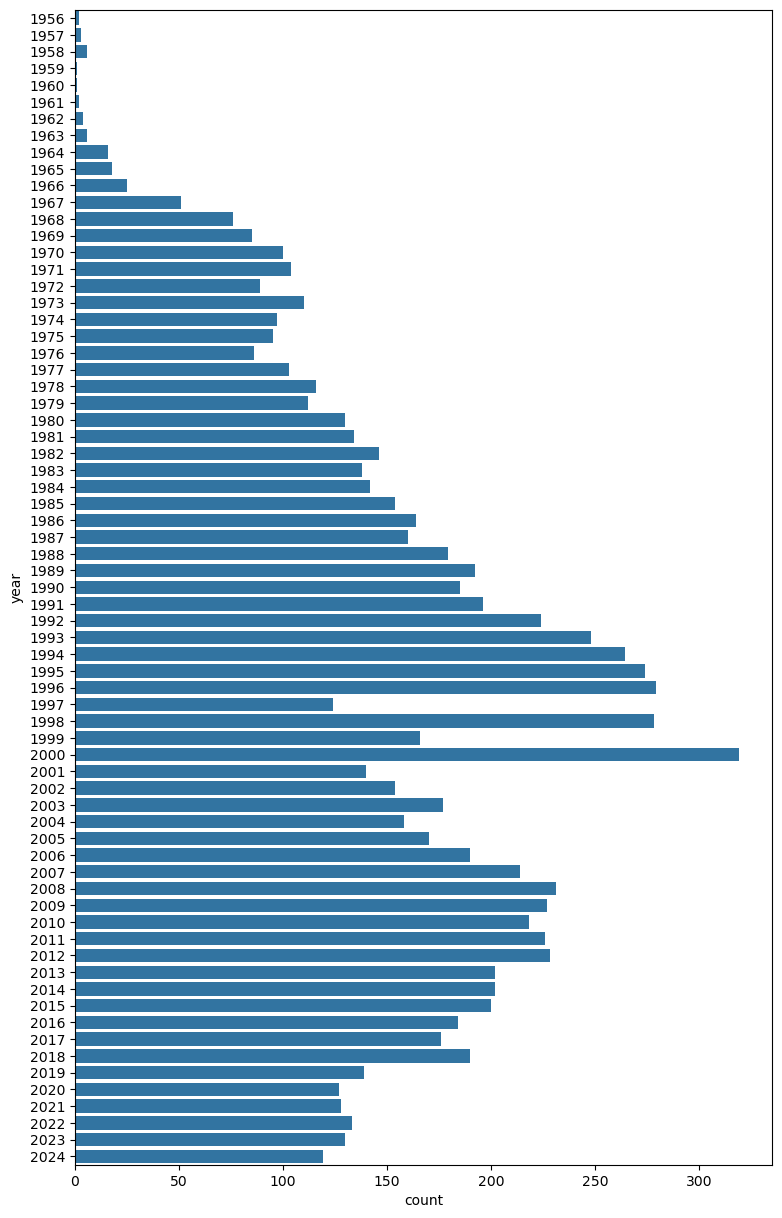

In [127]:
plt.figure(figsize=(9,15))
sns.countplot(data=df_masters_blended, y='year')

<Axes: xlabel='count', ylabel='year'>

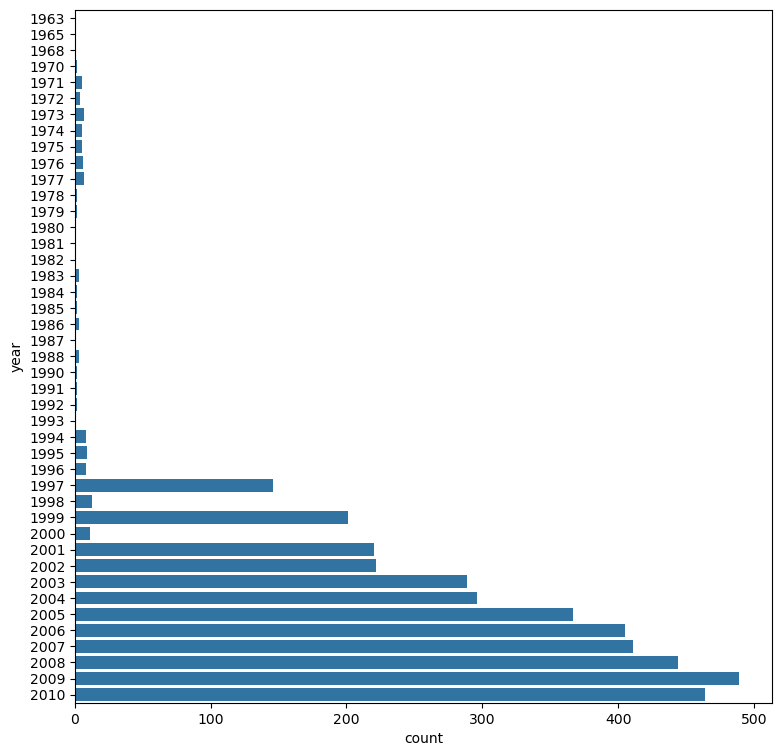

In [125]:
plt.figure(figsize=(9,9))
sns.countplot(data=df_us_new_masters_2010, y='year')

In [138]:
df_masters = pd.concat([df_masters_blended, df_us_new_masters_2010])
df_masters.shape

(13742, 13)

In [139]:
df_masters = df_masters[df_masters['year']<2011].query("year > 1959")
df_masters.shape

(11346, 13)

<Axes: xlabel='count', ylabel='year'>

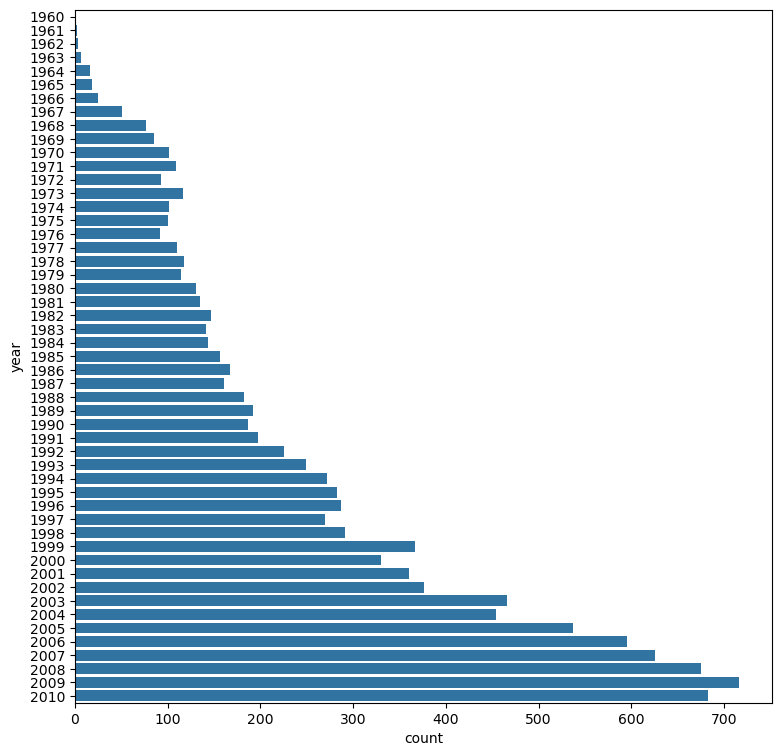

In [141]:
plt.figure(figsize=(9,9))
sns.countplot(data=df_masters, y='year')

In [143]:
df_masters.to_csv('Datasets/df_masters.csv', index=False)

# **``styles``**

In [2]:
df = pd.read_csv('Datasets/df_masters.csv')               # albums from the UK and US (until 2010) with >= 20 votes 
df.shape

(11346, 13)

In [3]:
df.sample(3)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2142,393492,139520,2030285,UK,Cressida,Asylum,1971,0.00,8,"['LP', 'Album']",['Rock'],['Prog Rock'],"English Prog-Rock Band, formed in 1968 and dis..."
6192,110253,17245,1284784,US,The Allman Brothers Band,Eat a Peach,1972,70.68,10,"['LP', 'Album']","['Rock', 'Blues']","['Blues Rock', 'Southern Rock']",American rock / blues band once based in Macon...
6676,91860,8140,152851,US,Lard,The Last Temptation of Reid,1990,57.10,9,['Album'],"['Electronic', 'Rock']","['Industrial', 'Punk']",Industrial-hardcore collaboration between Jell...


In [10]:
df.styles.value_counts().head(10)

styles
['Alternative Rock']    475
['Indie Rock']          427
['Death Metal']         289
['Punk']                268
['Hardcore']            263
['Heavy Metal']         258
['Pop Rock']            249
['Hard Rock']           247
['Prog Rock']           180
['Hardcore', 'Punk']    153
Name: count, dtype: int64

## **Looking for the missing ``styles``**

My approach is to get the styles from other releases of that album, because from the master release it said it had no styles.

In [6]:
percentage_styles_missing = round((df['styles']=='[]').sum() / df.shape[0] * 100, 2)

print(f"albums missing style: {(df['styles']=='[]').sum()} ")
print(f'% missing styles: {percentage_styles_missing}%')

albums missing style: 37 
% missing styles: 0.33%


### Testing

In [ ]:
# I am going to get the releases from the master_id, so I cannot search the albums where master_id = 0, I will search these ones manually
df[df['styles']=='[]'].query('master_id == 0')['title'].count()

0

In [16]:
# luckily all of them have a master_id
df_styles_missing = df[df['styles']=='[]'].query('master_id != 0') 
df_styles_missing.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
7506,732375,350751,2999284,US,Umphrey's McGee,Safety In Numbers,2006,68.05,13,"['LP', 'Album', 'Limited Edition']",['Rock'],[],Jam rock / progressive rock band from South Be...
7655,2588339,411298,3356736,US,Graves of Valor,Salarian Gate,2009,61.38,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Formed in December 2005 in Florence, South Car..."
7674,40916,292437,2590698,US,Kid Rock,Born Free,2010,60.67,13,['Album'],['Rock'],[],A self-proclaimed redneck from the midwestern ...
7796,266422,301354,8057533,UK & Europe,The Moody Blues,Strange Times,1999,57.55,14,['Album'],['Rock'],[],"British rock group from Birmingham, England, f..."
7833,924002,455567,3792209,US,Mat Kearney,Nothing Left to Lose,2006,56.97,13,['Album'],['Rock'],[],"American singer-songwriter born in Eugene, Ore..."


Let's test with one of these albums, The main release has ``stlyes = []``, but what about the other releases?

In [313]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100   # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'genre': 'Rock'
    , 'master_id': 3470389
}
response = requests.get(url, headers=headers, params=params)
data = response.json()
print(f"There are {len(data['results'])} releases of this album")

There are 8 releases of this album


Not all of them have ``styles = []``, some have some style at least.

In [314]:
# create an empty list
styles_list = []

# iterate over all the releases
for i in range(len(data['results'])):
    style = data['results'][i]['style'] # get the style(s)
    if style: 
        styles_list.append(style)
        most_common_style = pd.Series(styles_list).value_counts().idxmax()
    else:
        styles_list.append(np.nan)

# print the value_counts() of the styles
pd.Series(styles_list).value_counts()

[Prog Rock]    7
Name: count, dtype: int64

In [310]:
try:
    most_common_style = pd.Series(styles_list).value_counts().idxmax()
    print(most_common_style)
except:
    print('No styles found')

['Alternative Rock']


### **Applying the function to get ``df_styles_found``**

In [ ]:
def get_styles(df):

    most_common_styles = []
    count = 0

    for master_id in df_styles_missing['master_id'].values:
        time.sleep(1)
        count+=1
        url = "https://api.discogs.com/database/search"
        headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

        # Define parameters for artist search
        params = {
            "per_page": 100   # Number of results per page (max 100)
            , 'type': 'release'
            , 'format': 'album'
            , 'genre': 'Rock'
            , 'master_id': master_id
        }

        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # create an empty list
        styles_list = []

        # iterate over all the releases
        for i in range(len(data['results'])):
            style = data['results'][i]['style'] # get the style(s)
            if style: 
                styles_list.append(style)
            else:
                styles_list.append(np.nan)

        try:
            most_common_style = pd.Series(styles_list).value_counts().idxmax()
            print(f"{count} - {most_common_style}")
        except:
            print(f'{count} - No styles found')
            most_common_style = np.nan

        most_common_styles.append(most_common_style)
    
    df_styles_found = pd.DataFrame({'master_id': df_styles_missing['master_id'].values,
                                    'styles': most_common_styles})
    return df_styles_found

In [324]:
df_styles_missing = df[df['styles']=='[]'].query('master_id != 0')
df_styles_missing

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,20991,30254,1123069,UK,The Rolling Stones,Black and Blue,1976,41.15,8,"['LP', 'Album']",['Rock'],[],English rock band formed in London in May 1962...
9447,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
9955,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],[],American alternative rock band founded in 1989...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."


In [327]:
df_styles_found = get_styles(df_styles_missing)

No styles found
['Alternative Rock']
['Dream Pop', 'Indie Pop', 'Lo-Fi']
['Prog Rock']
['Pop Punk']
['Alternative Rock', 'Art Rock', 'Dream Pop']
['Grunge']
No styles found
['Alternative Rock', 'Indie Rock', 'Grunge', 'Alt-Pop']
['Post-Hardcore', 'Pop Punk']
['Alternative Rock', 'Post-Punk']
['Pop Rock']
['Prog Rock', 'Synth-pop', 'Alternative Rock', 'Pop Rock']
['Death Metal', 'Grindcore']
No styles found
['Alternative Rock', 'Indie Rock', 'Pop Rock']
['Alternative Rock']
['Indie Rock']
['Hard Rock']
['Alternative Rock']
['Alternative Rock']
['Pop Rock', 'Folk Rock']
['Alternative Rock']
['Goth Rock', 'Post-Punk', 'Alternative Rock']
['Indie Rock']
['Alternative Rock', 'Indie Rock']
['Rock & Roll', 'Punk']
No styles found
['Folk Rock', 'Neofolk']
['Indie Rock', 'Country', 'Folk Rock']
['Ska']
['Alternative Rock']
['Alternative Rock']
No styles found
['Indie Pop', 'Dance-pop', 'Nu Metal']
['Alternative Rock']
['Indie Rock']
['Symphonic Rock']
['Pop Rock']
['Alternative Rock', 'Indie Ro

In [328]:
df_styles_found

,master_id,styles
0,3540907,NaN
1,3527840,[Alternative Rock]
2,3471745,"[Dream Pop, Indie Pop, Lo-Fi]"
3,3470389,[Prog Rock]
4,3469978,[Pop Punk]
...,...,...
210,30254,[Classic Rock]
211,27951,[Folk Rock]
212,20565,"[Post Rock, Indie Rock]"
213,14043,[Blues Rock]


### **Replacing null values in ``df_styles_found``**

In [503]:
# create a df with where style is a null value
nulls = df_styles_found[df_styles_found['styles'].isna()]
nulls.shape

(15, 2)

In [507]:
# so I can print the np.where and I save time
for master_id in nulls['master_id'].values:
    print(f"df_styles_found['styles'] = np.where(df_styles_found['master_id']=={master_id}, "['Rock']", df_styles_found['styles'])")

df_styles_found['styles'] = np.where(df_styles_found['master_id']==3064604, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2459566, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2007316, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1760531, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1470386, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1441419, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1328043, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1065693, '[Indie]', df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==994504, '[Indie]', df

In [584]:
# looking on the internet for the style of these albums
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1433078, "['Indie Rock']", df_styles_found['styles'])
df_styles_found["styles"] = np.where(df_styles_found["master_id"]==3540907, "['Pop Rock']", df_styles_found["styles"])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==3064604, "['Alternative Rock', 'Space Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2459566, "['Pop Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==2007316, "['Alternative Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1760531, "['Post-Punk']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1470386, np.nan, df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1441419, "['Indie Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1328043, "['Alternative Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==1065693, "['Progressive Metal']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==994504, "['Post-Punk']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==910041, "['Nu Metal']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==886623, "['Pop Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==870411, "['Alternative Rock', 'Hard Rock']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==853786, "['Stoner Rock', 'Post-Hardcore']", df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==797067, np.nan, df_styles_found['styles'])
df_styles_found['styles'] = np.where(df_styles_found['master_id']==687999, "['Alternative Rock', 'Pop Punk']", df_styles_found['styles'])

print(f"Rows before dropping: {df_styles_found.shape[0]}")
df_styles_found.dropna(subset='styles', inplace=True)
print(f"Rows after dropping: {df_styles_found.shape[0]}")

Rows before dropping: 213
Rows after dropping: 213


In [524]:
# look for the albums by the master_id
df[df['master_id']==687999]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2144,3348883,687999,4683206,UK,Mallory Knox,Signals,2013,41.18,11,['Album'],['Rock'],[],Mallory Knox is a four-piece alternative rock ...


In [585]:
# save it in a .csv just in case
df_styles_found.to_csv('Datasets/df_styles_found.csv', index=False)

In [439]:
# in case I have to import it again
df_styles_found = pd.read_csv('Datasets/df_styles_found.csv')

### **Changing the type of ``styles``**

In [440]:
df.shape

(11429, 13)

In [441]:
df.styles.nunique()

3582

In [442]:
df.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."


**Separate ``df`` in 2 dataframes, one with the correct styles and the other df where ``styles = []``**

In [443]:
df_styles_empty = df[df['styles']=='[]']
df_styles_empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
51,9657940,3540907,31203097,UK,Remi Wolf,Big Ideas,2024,43.18,13,"['Album', 'Stereo']","['Rock', 'Pop']",[],"American singer-songwriter, born February 2, 1..."
58,2727700,3527840,31083689,Worldwide,Imagine Dragons,LOOM,2024,31.45,10,"['AAC', 'Album']","['Rock', 'Pop']",[],"Pop rock band from Nevada, US.\r\nFormed 2008\..."
80,7236492,3471745,30507286,US,Mk.Gee,Two Star and the Dream Police,2024,33.22,12,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']",[],NaN
81,4423684,3470389,29692129,Worldwide,Vennart,Forgiveness and The Grain,2024,42.03,8,"['MP3', 'Album']",['Rock'],[],Collaborative project led by English electric ...
82,48263,3469978,30524809,US,Microwave,Let's Start Degeneracy,2024,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],[],"Rock band from Atlanta, Georgia consisting of ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[],"Born December 7th. 1949, in Pomona, California..."
10498,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",[],"American singer-songwriter, multi-instrumental..."
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.00,10,"['LP', 'Album']",['Rock'],[],"Rock group that was started in Seattle, in 196..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.00,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."


In [444]:
df_styles_good = df[df['styles']!='[]']
df_styles_good

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"['Blackgaze', 'Post-Hardcore', 'Post-Metal']","Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Emo', 'Math Rock', 'Pop Punk']","Trio from Benson, Minnesota. The band takes in..."
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"['Alternative Rock', 'Folk Rock']",American singer/songwriter originally from Roc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11424,29890,0,11013751,UK,The Clash,The Clash,1977,34.85,14,"['LP', 'Album']",['Rock'],['Punk'],Influential British punk rock group from west ...
11425,292633,0,2493108,US,Converge,Halo In A Haystack,1994,0.00,10,"['LP', 'Album']",['Rock'],['Metalcore'],Converge is a hardcore punk and metal band tha...
11426,109320,0,11590028,US,Split Enz,Mental Notes,1976,41.88,10,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Split Enz were a rock band from New Zealand fo...
11427,85929,0,9727763,UK,Kate Bush,Lionheart,1978,36.57,10,"['LP', 'Album', 'Promo']","['Rock', 'Pop']","['Art Rock', 'Pop Rock', 'Ballad']","Highly distinctive singer/songwriter, born Jul..."


It looks like they are lists, but actually...

In [445]:
type(df_styles_good.styles[0])

str

In [446]:
# convert these strings to lists
df_styles_good.styles = df_styles_good.styles.apply(ast.literal_eval)
type(df_styles_good.styles[0])

list

In [447]:
df_styles_good.head(2)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],[Post-Hardcore],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.0,13,['Album'],['Rock'],"[Alternative Rock, Pop Punk]","Band from Dover Plains, New York, formerly kno..."


In [448]:
df_styles_good['styles'].value_counts().head()

styles
[Indie Rock]          550
[Alternative Rock]    489
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            266
Name: count, dtype: int64

### **Merge with ``df_styles_found``**

In [544]:
# to copy them for later sorting the columns in the merged df
df_styles_empty.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [587]:
df_styles_merged = pd.merge(df_styles_empty, df_styles_found, on=['master_id'])
df_styles_merged.drop(columns='styles_x', inplace=True)
df_styles_merged.rename(columns={'styles_y': 'styles'}, inplace=True)

# sort the columns
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country', 'artist', 'title', 'year',
                   'album_length', 'tracks', 'release_type', 'genres', 'styles', 'artist_profile']
df_styles_merged = df_styles_merged[list_of_columns]
df_styles_merged.shape

(213, 13)

In [546]:
# check everything is fine
df_styles_merged.sample(3)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
109,256629,897370,7584880,US,Coheed and Cambria,The Color Before The Sun,2015,47.22,10,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],A progressive rock band based out of Nyack and...
160,286546,292999,2324957,Germany,Peter Criss,Let Me Rock You,1982,0.00,10,"['LP', 'Album']",['Rock'],['Rock & Roll'],"George Peter John Criscuola (born December 20,..."
38,11073,1601626,14089728,US,Iggy Pop,Free,2019,33.38,10,['Album'],"['Jazz', 'Rock']",['Pop Rock'],"American singer, songwriter, musician and acto..."


### **Albums where ``master_id = 0``**

In [452]:
# create a subset with the albums where master_id = 0 and style is empty. These albums I cannot find the styles for other releases because the master_id = 0
df_styles_empty_id0 = df_styles_empty[df_styles_empty['master_id']==0]
df_styles_empty_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.0,10,"['LP', 'Album']",['Rock'],[],"Rock group that was started in Seattle, in 196..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.0,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."
11365,4266257,0,6684240,US,Savage Garden,Savage Garden,1989,0.0,7,"['Single Sided', 'Album']",['Rock'],[],NaN


In [453]:
# looking on the internet for the style of these albums
df_styles_empty_id0.loc[11330, 'styles'] = '[Hard Rock, Folk Rock, Pop Rock]'

In [416]:
df[df['artist']=='Nirvana']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
8373,125246,42473,367273,US,Nirvana,From the Muddy Banks of the Wishkah,1996,53.92,17,['Album'],['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
10334,125246,13859,375979,US,Nirvana,In Utero,1993,41.00,12,['Album'],['Rock'],"['Grunge', 'Alternative Rock']","Rock band from Aberdeen, Washington, USA, form..."
10339,125246,13814,367084,US,Nirvana,Nevermind,1991,42.53,12,"['Album', 'Mispress']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
10343,125246,13773,2795554,US,Nirvana,Bleach,1989,0.00,11,"['LP', 'Album', 'Limited Edition']",['Rock'],['Grunge'],"Rock band from Aberdeen, Washington, USA, form..."
11331,6117976,0,10489702,US,Nirvana,Nirvana,1990,0.00,11,['Album'],['Rock'],[],"Nirvana is hard rock/AOR band, from Los Angele..."


In [417]:
df.loc[11331, 'artist_profile']

'Nirvana is hard rock/AOR band, from Los Angeles, California, USA. Not to be confused with the grunge band [a=Nirvana] from Washington.\r\n\r\nThis band features Bert Klugkist, Mark Wiggins, Erik Wiggins and Rick Obradors.'

In [454]:
# it's not the Nirvana we all know, it's a different band and I cannot even find any information about this band outside Discogs, so I drop it
df_styles_empty_id0.drop(11331, axis=0, inplace=True)

In [455]:
df[df['artist']=='Savage Garden']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11365,4266257,0,6684240,US,Savage Garden,Savage Garden,1989,0.0,7,"['Single Sided', 'Album']",['Rock'],[],NaN


In [456]:
# I can only find a band named like this, but the album is from 1997 (strange). Anyway, they are Australian, so I drop it
df_styles_empty_id0.drop(11365, axis=0, inplace=True)

In [457]:
df_styles_empty_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
11330,136201,0,17501914,UK,Heart,Little Queen,1977,39.0,10,"['LP', 'Album']",['Rock'],"[Hard Rock, Folk Rock, Pop Rock]","Rock group that was started in Seattle, in 196..."


### **Concat ``df_styles_good`` with ``df_styles_merged`` and ``df_styles_empty_id0``**

In [559]:
type(df_styles_merged.styles[0]) # each element should be a list

str

In [589]:
# convert these strings to lists
df_styles_merged.styles = df_styles_merged.styles.apply(ast.literal_eval)
type(df_styles_merged.styles[0])

list

In [590]:
df_masters_blended = pd.concat([df_styles_good, df_styles_merged, df_styles_empty_id0])
df_masters_blended.shape

(11425, 13)

In [595]:
df_styles_good['styles'].value_counts().head()

styles
[Indie Rock]          550
[Alternative Rock]    489
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            266
Name: count, dtype: int64

In [596]:
df_masters_blended['styles'].value_counts().head()

styles
[Indie Rock]          576
[Alternative Rock]    525
[Death Metal]         306
[Heavy Metal]         287
[Pop Rock]            279
Name: count, dtype: int64

By printing the ``value_counts()`` of each dataframe I make sure the albums that had ``styles = []`` are now included, we can see the count has increased

In [597]:
df_masters_blended

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],[Post-Hardcore],"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"[Alternative Rock, Pop Punk]","Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],"[Blackgaze, Post-Hardcore, Post-Metal]","Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"[Emo, Math Rock, Pop Punk]","Trio from Benson, Minnesota. The band takes in..."
4,2607662,3659271,32308731,US,Father John Misty,Mahashmashana,2024,0.00,8,"['LP', 'Album', 'Club Edition', 'Limited Editi...",['Rock'],"[Alternative Rock, Folk Rock]",American singer/songwriter originally from Roc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,59792,27951,2769931,US,Bob Dylan,Knocked Out Loaded,1986,34.85,8,"['LP', 'Album']","['Rock', 'Pop']",[Folk Rock],"Born: May 24, 1941, Duluth, Minnesota, USA; si..."
210,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],"[Post Rock, Indie Rock]",American alternative rock band founded in 1989...
211,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",[Blues Rock],"Born December 7th. 1949, in Pomona, California..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']","[Pop Rock, Classic Rock]","American singer-songwriter, multi-instrumental..."


In [601]:
df_masters_blended.to_csv('Datasets/df_masters_blended.csv', index=False)

In [602]:
df_masters_blended.explode('styles')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Blackgaze,"Post-black metal band from Sheffield, UK\r\n\r..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,252314,20565,1113832,US,Jawbox,Jawbox,1996,46.28,15,['Album'],['Rock'],Indie Rock,American alternative rock band founded in 1989...
211,82294,14043,435679,US,Tom Waits,Foreign Affairs,1977,41.88,9,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock', 'Blues']",Blues Rock,"Born December 7th. 1949, in Pomona, California..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",Pop Rock,"American singer-songwriter, multi-instrumental..."
212,63332,11771,1813397,US,Lenny Kravitz,5,1998,66.42,13,['Album'],"['Rock', 'Funk / Soul']",Classic Rock,"American singer-songwriter, multi-instrumental..."


## **explode ``styles`` in one line of code**

In [603]:
# import the dataframe
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')
df_masters_blended.shape

(11425, 13)

In [604]:
type(df_masters_blended['styles'][0])

str

In [43]:
df_masters_blended['styles'] = df_masters_blended["styles"].apply(ast.literal_eval)
df_styles = df_masters_blended.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

for style in top_80_styles:
    print(style)

Alternative Rock
Punk
Pop Rock
Indie Rock
Hard Rock
Folk Rock
Psychedelic Rock
Heavy Metal
Country Rock
Blues Rock
Experimental
Hardcore
Rock & Roll
Garage Rock
Soft Rock
Prog Rock
AOR
Power Pop
Acoustic
New Wave
Thrash
Folk
Classic Rock
Country
Avantgarde
Lo-Fi
Art Rock
Southern Rock
Gospel
Ska
Death Metal
Synth-pop
Jazz-Rock
Rockabilly
Surf
Ballad
Industrial
Vocal
Soul
Funk
Grunge
Noise
Rhythm & Blues
Religious
Goth Rock
Pop Punk
Lounge
Fusion
Glam
Post-Punk
Emo
Nu Metal
Ambient
Funk Metal
Space Rock
Post Rock
Arena Rock
Disco
Ethereal
Soundtrack
Progressive Metal
Speed Metal
Stoner Rock
Indie Pop
Easy Listening
Power Metal
Doom Metal
Free Improvisation
Parody
Doo Wop
Beat
Shoegaze
Abstract
Jazz-Funk
New Age
Acid Rock
Symphonic Rock
Electro
Bluegrass
Math Rock


## ``explode`` in several lines of code

In [44]:
df['styles'].value_counts().head()

styles
[Indie Rock]          558
[Alternative Rock]    497
[Death Metal]         358
[Heavy Metal]         300
[Pop Rock]            274
Name: count, dtype: int64

In [45]:
df.shape

(11920, 13)

In [46]:
df_styles = df.explode('styles')
df_styles.shape

(23859, 13)

In [47]:
df_styles['styles'].nunique()   # before we had 3851

276

In [48]:
df_styles['styles'].value_counts().head(80)

styles
Alternative Rock         2075
Indie Rock               1993
Pop Rock                 1314
Hard Rock                1035
Punk                      987
                         ... 
Krautrock                  48
Gothic Metal               48
Industrial Metal           47
AOR                        47
Technical Death Metal      47
Name: count, Length: 80, dtype: int64

## Get the nº of albums for each ``style`` for one specific year

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

styles_to_get = [ 
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Indie Pop", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

styles_list = []
count_list = []

for style in styles_to_get:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': 1997
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")
    time.sleep(2)

    styles_list.append(style)
    count_list.append(items_number)

# save the data in a df
data = pd.DataFrame({'style': styles_list, 'albums': count_list})

Alternative Rock: 1853
Indie Rock: 1292
Pop Rock: 1038
New Wave: 80
Emo: 195
Post Rock: 183
Shoegaze: 53
Indie Pop: 179
Hard Rock: 792
Heavy Metal: 444
Death Metal: 162
Thrash: 197
Black Metal: 74
Doom Metal: 37
Metalcore: 37
Progressive Metal: 41
Stoner Rock: 63
Speed Metal: 32
Nu Metal: 134
Prog Rock: 291
Psychedelic Rock: 360
Art Rock: 172
Classic Rock: 219
Space Rock: 56
Symphonic Rock: 39
Punk: 1493
Hardcore: 759
Post-Punk: 65
Post-Hardcore: 38
Pop Punk: 176
Grunge: 163
Garage Rock: 308
Folk Rock: 525
Blues Rock: 406
Rock & Roll: 257
Soft Rock: 215
Country Rock: 445
Southern Rock: 120


In [78]:
data.head()

,style,albums
0,Alternative Rock,1853
1,Indie Rock,1292
2,Pop Rock,1038
3,New Wave,80
4,Emo,195


In [79]:
data.albums.sum()

12993

In [80]:
((data.albums.sum())*1.5)/3600

5.41375

## Top 80 styles for one year in the US

In [ ]:
# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles'] = df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

In [ ]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles'] = df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()
styles_list = []
count_list = []

for style in top_80_styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': 2004
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")
    time.sleep(2)

    styles_list.append(style)
    count_list.append(items_number)

# save the data in a df and export it
data = pd.DataFrame({'style': styles_list, 'albums': count_list})

OSError: [Errno 22] Invalid argument: 'Datasets/df_us_masters.csv'

In [ ]:
data = data.sort_values('albums', ascending=False)
data.reset_index(drop=True, inplace=True)
data

,style,albums
0,Punk,1666
1,Alternative Rock,1495
2,Indie Rock,1438
3,Pop Rock,1107
4,Hardcore,849
...,...,...
75,Doo Wop,18
76,Jazz-Funk,14
77,New Age,11
78,Disco,9


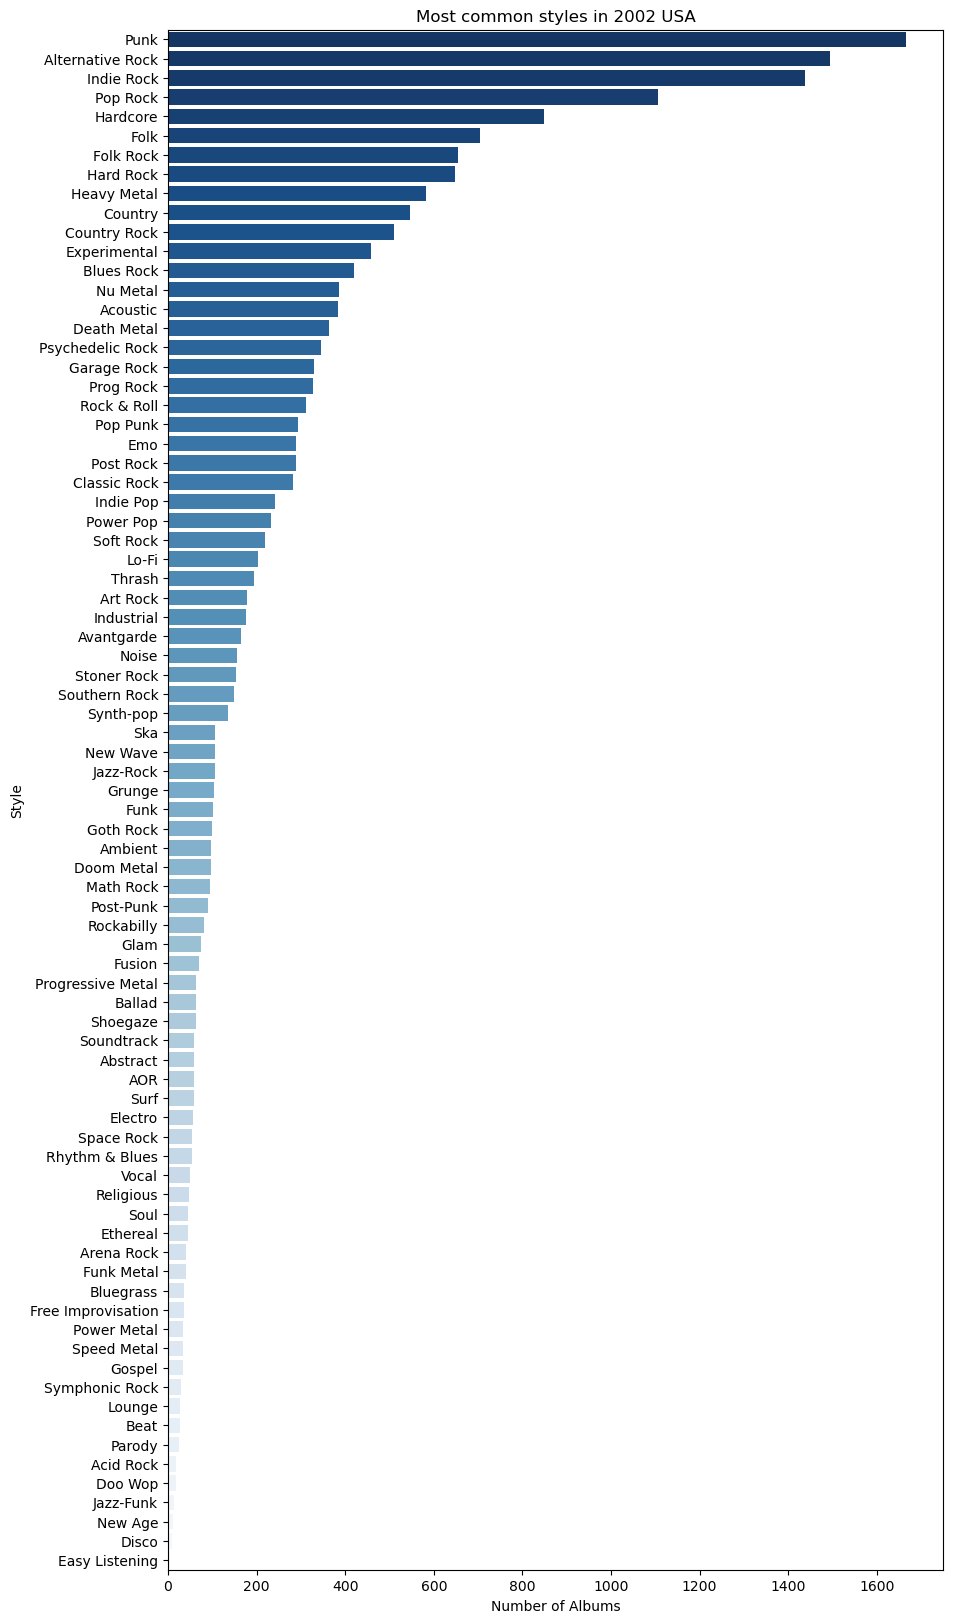

In [ ]:
plt.figure(figsize=(10, 20))
sns.barplot(data=data, y="style", x="albums", palette="Blues_r")
plt.xlabel("Number of Albums")
plt.ylabel("Style")
plt.title("Most common styles in 2002 USA")
plt.show()

## Top 50 styles for all the albums, UK and US

In [ ]:
df = pd.read_csv('Datasets/df_masters_blended.csv')
df['styles'] = df["styles"].apply(ast.literal_eval)
df_styles = df.explode('styles')
top_50_styles = df_styles['styles'].value_counts().head(50).index.to_list()

In [ ]:
df_styles['styles'].value_counts().head(50)

styles
Alternative Rock     2075
Indie Rock           1993
Pop Rock             1314
Hard Rock            1035
Punk                  987
Heavy Metal           976
Prog Rock             824
Hardcore              664
Death Metal           654
Psychedelic Rock      634
Folk Rock             632
Experimental          581
Thrash                482
Art Rock              415
Blues Rock            405
Black Metal           389
New Wave              329
Synth-pop             273
Doom Metal            267
Classic Rock          263
Emo                   255
Acoustic              249
Post-Punk             241
Post Rock             240
Avantgarde            235
Rock & Roll           220
Metalcore             204
Progressive Metal     204
Soft Rock             195
Post-Hardcore         185
Shoegaze              183
Industrial            180
Country Rock          177
Indie Pop             160
Glam                  159
Pop Punk              157
Stoner Rock           146
Speed Metal           146
Garag

In [ ]:
df_styles[df_styles['styles']=='Art Rock'].year.mean()

1993.6722891566264

In [ ]:
df_styles[df_styles['styles']=='Punk']['artist'].count()

987

### **Styles analysis** for number of albums and average year

In [ ]:
# get the average year of each style
top_50_styles = df_styles['styles'].value_counts().head(100)
top_styles = df_styles['styles'].value_counts().head(100).index.to_list()
albums = top_50_styles.values
years = []
styles = []
albums_count = []

for style in top_styles:
    avg_year = int(df_styles[df_styles['styles']==style].year.mean())
    albums = df_styles[df_styles['styles']==style]['artist'].count()
    years.append(avg_year)
    styles.append(style)
    albums_count.append(albums)

df_styles_years = pd.DataFrame({'style': styles, 'albums': albums_count, 'avg_year': years})

In [ ]:
df_styles_years.sort_values('albums', ascending=False).tail(50)

,style,albums,avg_year
50,Fusion,93,1982
51,Grindcore,92,2002
52,Nu Metal,90,2005
53,Ballad,87,1995
54,Electro,86,2007
55,Sludge Metal,82,2009
56,Downtempo,80,2004
57,Goth Rock,78,1994
58,Southern Rock,77,1989
59,Ethereal,74,1999


**Styles Grouping (1960s–2020s Focus)**

**1. Alternative & Indie Rock (80s–2020s)**

✅ Alternative Rock, Indie Rock, Pop Rock, New Wave, Emo, Post Rock, Shoegaze, Indie Pop 

**2. Hard Rock & Metal (70s–2020s)**

✅ Hard Rock, Heavy Metal, Death Metal, Thrash, Black Metal, Doom Metal, Metalcore, Progressive Metal, Stoner Rock, Speed Metal, Nu Metal

**3. Classic & Psychedelic Rock (60s–80s, some revival)**

✅ Prog Rock, Psychedelic Rock, Art Rock, Classic Rock, Space Rock, Symphonic Rock

**4. Punk & Hardcore (70s–2020s)**

✅ Punk, Hardcore, Post-Punk, Post-Hardcore, Pop Punk, Grunge, Garage Rock

**5. Roots Rock & Blues (50s–present)**

✅ Folk Rock, Blues Rock, Rock & Roll, Soft Rock, Country Rock, Southern Rock

**What to Drop? (Even for the 60s–2020s range)**

These styles aren’t really rock in any decade:

❌ Easy Listening, New Age, Free Improvisation, Abstract, Rhythm & Blues, Doo Wop, Soul, Bluegrass, Vocal, Ballad, Jazz-Funk, Disco, Funk

Why? They either:
- Weren’t major parts of the rock genre (Disco, Funk, Soul, R&B, etc.).
- Were independent movements that didn't blend much with rock (New Age, Easy Listening, Jazz-Funk).

In [ ]:
df_styles[df_styles['styles']=='Arena Rock']['artist'].value_counts()

artist
Def Leppard           8
Scorpions             4
Heart                 4
Asia                  4
Journey               4
Dokken                3
Kansas                3
Meat Loaf             3
Uriah Heep            3
Boston                3
Phish                 3
AC/DC                 2
Ratt                  2
Mr. Big               2
Foreigner             2
Magnum                2
Firehouse             2
Europe                2
Queen                 2
REO Speedwagon        2
Triumph               2
Kix                   2
Aerosmith             2
KISS                  1
Frank Zappa           1
The Darkness          1
Roger Waters          1
Deep Purple           1
Survivor              1
Pink Floyd            1
Neil Young            1
Guns N' Roses         1
Joe Satriani          1
Bad Company           1
Yes                   1
Slade                 1
Mr. Mister            1
Praxis                1
Loverboy              1
Simple Minds          1
U2                    1
Andrew W.

In [ ]:
df_styles[df_styles['styles']=='Garage Rock']['artist'].count()

145

In [ ]:
df_styles[df_styles['styles']=='Rockabilly']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
4408,272426,252597,4057583,US,Buddy Holly,Buddy Holly,1958,0.00,12,"['LP', 'Album']","['Rock', 'Pop']",Rockabilly,"American guitarist, singer and songwriter, bes..."
4886,49624,210587,13285348,South Korea,Jeff Beck,Crazy Legs,1993,40.52,18,['Album'],['Rock'],Rockabilly,"British guitarist.\r\nBorn: June 24, 1944, in ..."
5184,272426,183346,1371149,US,Buddy Holly,That'll be the Day,1958,25.15,11,"['LP', 'Album', 'Mono']",['Rock'],Rockabilly,"American guitarist, singer and songwriter, bes..."
6366,27518,107325,4814324,US,Elvis Presley,Elvis Presley,1956,0.00,12,"['LP', 'Album', 'Mono']","['Rock', 'Pop']",Rockabilly,American singer.\r\nBorn: 8 January 1935 in Ea...
7060,253328,83700,900466,Australia,The Living End,State Of Emergency,2006,51.73,14,['Album'],['Rock'],Rockabilly,"Punk rock band from Melbourne, Australia.\r\nF..."
7061,253328,83698,373583,Australia,The Living End,The Living End,1998,47.00,14,['Album'],['Rock'],Rockabilly,"Punk rock band from Melbourne, Australia.\r\nF..."
7320,135946,73462,5780483,US,Johnny Cash,I Walk The Line,1964,32.32,12,"['LP', 'Album', 'Mono']","['Rock', 'Folk, World, & Country']",Rockabilly,"Johnny Cash was an American singer-songwriter,..."
7321,135946,73420,7684728,US,Johnny Cash,The Fabulous Johnny Cash,1958,0.00,12,"['LP', 'Album', 'Mono']","['Rock', 'Folk, World, & Country']",Rockabilly,"Johnny Cash was an American singer-songwriter,..."
7470,180921,69584,1690027,UK,Stray Cats,Stray Cats,1981,0.00,12,"['LP', 'Album']",['Rock'],Rockabilly,The Stray Cats are a rockabilly band first for...
7472,180921,69576,1346627,UK,Stray Cats,Gonna Ball,1981,32.77,11,"['LP', 'Album']",['Rock'],Rockabilly,The Stray Cats are a rockabilly band first for...


# **``album_length``**

In [5]:
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df = df_masters_blended
df.shape

(9667, 13)

In [6]:
percentage_album_length_missing = round((df['album_length']==0).sum() / df.shape[0] * 100, 2)

print(f"albums missing album_length: {(df['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 2234 
% missing album_length: 23.11%


In [7]:
df_length_0 = df[df['album_length']==0].sort_values(['artist', 'year', 'title'])
df_length_0.shape

(2234, 13)

In [4]:
df_lengths_missing_concat = pd.read_csv('Datasets/df_lengths_missing_concat.csv')
df_lengths_missing_concat.shape

(1922, 5)

## **Examining**

In [10]:
df_length_0.iloc[8:15]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
8451,253271,17226,3944276,US,7 Seconds,New Wind,1986,0.0,13,"['LP', 'Album']",['Rock'],"['Punk', 'Hardcore']","Punk band originally from Reno, Nevada, formed..."
7647,11203,30962,1453338,UK,A Certain Ratio,The Graveyard and The Ballroom,1980,0.0,16,['Album'],"['Electronic', 'Rock']","['Leftfield', 'New Wave']",British post punk & indie funk band formed in ...
1719,652118,695019,6340275,US,A Global Threat,Until We Die,2000,0.0,14,['Album'],['Rock'],"['Hardcore', 'Punk']",A Global Threat was an American street punk ba...
1784,1922448,666120,5690473,US,A Loss For Words,The Kids Can't Lose,2009,0.0,11,[],"['Rock', 'Pop']",['Pop Punk'],A Loss for Words (formerly Last Ride) is an Am...
1562,875613,793004,6598160,US,A Place to Bury Strangers,Transfixiation,2015,0.0,11,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Indie Rock', 'Shoegaze', 'Noise Rock']",New York based noise rock and shoegaze band.\r...
241,5042878,2981294,26115777,US,A Wake in Providence,Eternity,2022,0.0,9,"['LP', 'Album', 'Limited Edition']",['Rock'],['Deathcore'],NaN
1955,1198658,576161,5062357,Australia,A.A. Bondy,Believers,2011,0.0,10,['Album'],['Rock'],"['Indie Rock', 'Folk Rock']",A.A. Bondy is actually the birth name (the ini...


In [11]:
df_lengths_missing_concat.iloc[8:15]

,artist,title,name,album_length,tracks
8,7 Seconds,New Wind,new wind,38.97,14
9,A Global Threat,Until We Die,until we die,27.51,14
10,A Loss For Words,The Kids Can't Lose,the kids can't lose,34.56,11
11,A Place to Bury Strangers,Transfixiation,transfixiation,39.33,11
12,A Wake in Providence,Eternity,eternity,42.93,9
13,A.A. Bondy,Believers,believers,40.91,10
14,A.R. Kane,69,69,40.46,10


## **``Spotipy`` (Spotify API)**

In [15]:
load_dotenv()

True

In [16]:
user = os.getenv('client_id')
password = os.getenv('client_secret')

# Initialize Spotipy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password), requests_timeout=10)

### Testing

In [17]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

In [18]:
artist = '108'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name.lower() == artist.lower():
    print(f"artist found: {artist_name} with id '{artist_id}'")
else:
    print(f"Cannot find '{artist}', try some other one")

artist found: 108 with id '3j2S24uHONLPeKvYjG14oH'


In [19]:
albums = get_all_albums(artist_id)

In [20]:
for i in albums:
    print(i['name'])

18.61
A New Beat from a Dead Heart
Creation. Sustenance. Destruction.
Songs Of Separation
Violent World: A Tribute To The Misfits


In [ ]:
artist = '108'
title = 'A New Beat From A Dead Heart'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

artists = results['artists']['items']
artists_ids = results['artists']['items'] # get the artist_id

for i in range(len(artists)):
    # artist = artists[i]['name']
    try:
        # look for my artist
        if artist.lower().replace('and', '&') == artists[i]['name'].lower():
            # if it finds my artist:
            artist_id = artists_ids[i]['id']
            print('artist found')
            print(artist)

            artist_albums = get_all_albums(artist_id)

            for album in artist_albums:

                print(album['name'])

                # look for my album
                if album['name'].lower().replace('and', '&') == (title.lower().replace('and', '&')):
                    print('album found')
                    album_id = album['id']
                    results = sp.album(album_id)
                    tracks = results['tracks']['items']
                    song_durations = [song['duration_ms']/60000 for song in tracks]
                    
                    album_length = round(sum(song_durations), 2)

                    break   # once it finds the album, stop
    except:
        print('error')            

artist found
108
18.61
A New Beat from a Dead Heart
album found
artist found
108
Mission Infinite
artist found
108
05s identity
Metta Muzik, Vol. 2
Flex skill
RE:BORN
OVER THE BORDER
kitanoshiro (feat. 108)
Empty Heart (feat. ZiiFlex a.k.a ZIMA) [Remix]


Here we can see that the album is found, though not on the exact same name, it doesn't do an exact match because there are other parts in the title, such as **'Deluxe Edition'** or **'Remastered'**

In [1078]:
len(artist_albums)

31

In [1082]:
artist_albums[0]['name']

'Kings of the Wild Frontier (Deluxe Edition)'

In [952]:
artist_id

'2jK54ZlZhTF1TxygsVeR05'

### **define the functions**

In [973]:
def get_album_length(df):
    count = 0
    scrapped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(2)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            try:
                # look for my artist
                if artist == artists[i]['name']:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    # get the albums of the artist
                    results = sp.artist_albums(artist_id, limit=50)
                    data = results['items']

                    # examine all the albums
                    for j in range(len(data)):
                        album = data[j]['name']
                        album_id = data[j]['id']

                    # for album in artist_albums:
                    for j in range(len(data)):
                        album = data[j]['name']
                        album_id = data[j]['id']

                        # look for my album
                        if album.lower() == title.lower():
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scrapped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break   
            except:
                print('error')
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scrapped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]
        # for lst in lists:
        #     print(len(lst))

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

In [9]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

**La següent funciona però no és la millor**

In [10]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(1)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    artist_albums = get_all_albums(artist_id)

                    for album in artist_albums:
                        album_name = album['name'].lower()        
                        title_name_and = title.replace('and', '&').lower()
                        if title.lower() in album_name or title_name_and in album_name:
                            time.sleep(1)
                            album_id = album['id']
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scraped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break 
            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scraped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

### **Get the ``album_length`` from Spotipy**

In [ ]:
start_index = 100
end_index = start_index + 100

df_lengths_missing = get_album_length(df_length_0.iloc[start_index:end_index])
df_lengths_missing.shape

In [2]:
64875/3600

18.020833333333332

In [919]:
minutes = 12.25
attempts = 500

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

1.47

In [2]:
df_lengths_missing

NameError: name 'df_lengths_missing' is not defined

## **Wikipedia scraping**

In [2]:
df_length_to_do = pd.read_csv('Datasets/df_length_to_do.csv')
df_length_to_do.shape

(408, 13)

#### Testing

In [ ]:
df = pd.read_csv('Datasets/df_length_to_do.csv')

artists_list = []
titles_list = []
lengths_list = []
count=0
scraped=0

artist = '3'
title = 'Wake Pig'

title_changed = title.replace(' ', '_')
count+=1
artists_list.append(artist)  
titles_list.append(title)

try:
    url = f"https://en.wikipedia.org/wiki/{title_changed}"
    response = requests.get(url).content
    soup = BeautifulSoup(response, "html.parser")

    table = soup.select('#mw-content-text > div.mw-content-ltr.mw-parser-output > table.infobox')

                        #mw-content-text > div.mw-content-ltr.mw-parser-output > table

    length = table[0].text.split('Length')[1].split('Label')[0]
    print(length)

# save info in lists
    lengths_list.append(length)
    scraped+=1

except:
    print('cannot find this album')
    lengths_list.append(np.nan)

print(f'{scraped}/{count}: {artist} - {title}')

46:5657:31 (re-release)
cannot find this album
0/1: 3 - Wake Pig


### **Running the function** (stored in a .py)

In [ ]:
df_length_to_do.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,317719,107693,1611310,US,16,Bridges to Burn,2009,0.0,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Hardcore', 'Downtempo', 'Southern Rock']","American sludge metal band from San Diego, Cal..."
1,513958,0,4834521,US,3,Summercamp Nightmare,2003,0.0,12,['Album'],['Rock'],"['Prog Rock', 'Heavy Metal']",American progressive rock/metal band from Wood...
2,513958,429178,9441550,US,3,Wake Pig,2004,0.0,11,['Album'],['Rock'],"['Alternative Rock', 'Hard Rock', 'Heavy Metal']",American progressive rock/metal band from Wood...
3,513958,429183,3436139,US,3,The End is Begun,2007,0.0,13,['Album'],['Rock'],['Heavy Metal'],American progressive rock/metal band from Wood...
4,11203,30962,1453338,UK,A Certain Ratio,The Graveyard and The Ballroom,1980,0.0,16,['Album'],"['Electronic', 'Rock']","['Leftfield', 'New Wave']",British post punk & indie funk band formed in ...


In [3]:
start_index = 0
final_index = start_index + 10

df_lengths_wikipedia = get_length_wikipedia(df_length_to_do, start_index, final_index)

1/1: 16 - Bridges to Burn
2/2: 3 - Summercamp Nightmare
3/3: 3 - Wake Pig
4/4: 3 - The End is Begun
4/5: A Certain Ratio - The Graveyard and The Ballroom
4/6: A Day In Black And White - Notes
4/7: A Thorn For Every Heart - Things Aren't So Beautiful Now
5/8: AFI - Answer That and Stay Fashionable
6/9: AFI - Shut Your Mouth and Open Your Eyes
6/10: Addaura - Addaura


### **Looking for the missing albums**

In [2]:
df_lengths_wikipedia = pd.read_csv('Datasets/df_lengths_wikipedia.csv')
df_lengths_wikipedia.shape

(408, 3)

In [3]:
df_lengths_wikipedia['album_length'].isna().sum()

242

**It only got around 40% of the albums**

In [4]:
df_lengths_wikipedia_nan = df_lengths_wikipedia[df_lengths_wikipedia['album_length'].isna()]
df_lengths_wikipedia_nan.shape

(242, 3)

In [5]:
df_lengths_wikipedia_nan

,artist,title,album_length
4,A Certain Ratio,The Graveyard and The Ballroom,NaN
5,A Day In Black And White,Notes,NaN
6,A Thorn For Every Heart,Things Aren't So Beautiful Now,NaN
9,Addaura,Addaura,NaN
10,Aftershock,Through The Looking Glass,NaN
...,...,...,...
401,Yaphet Kotto,The Killer Was in the Government Blankets,NaN
403,Yo La Tengo,Ride the Tiger,NaN
404,You and I,The Curtain Falls,NaN
405,Your Best Friend,Your Best Friend,NaN


**Testing before applying the function**

In [45]:
df = pd.read_csv('Datasets/df_length_to_do.csv')

artists_list = []
titles_list = []
lengths_list = []
count=0
scraped=0

artist = 'Roger Waters'
title = 'The Pros and Cons of Hitch Hiking'

title_changed = title.replace(' ', '_')
title_band = title_changed + ('_(album)')
count+=1
artists_list.append(artist)  
titles_list.append(title)

try:
    url = f"https://en.wikipedia.org/wiki/{title_changed}"
    print('the website exists')
    response = requests.get(url).content
    soup = BeautifulSoup(response, "html.parser")

    table = soup.select('body div')
    print(len(table))
    print(table)

# 'div div div', class_='infobox vevent haudio'
                            #mw-content-text > div.mw-content-ltr.mw-parser-output > table.infobox.vevent.haudio

    length = table[0].text.split('Length')[1].split('Label')[0]
    print(length)

# save info in lists
    lengths_list.append(length)
    scraped+=1

except:
    try:
        url = f"https://en.wikipedia.org/wiki/{title_band}"
        response = requests.get(url).content
        soup = BeautifulSoup(response, "html.parser")

        table = soup.select('mw-content-text > div.mw-content-ltr.mw-parser-output > table.infobox')

                            #mw-content-text > div.mw-content-ltr.mw-parser-output > table

        length = table[0].text.split('Length')[1].split('Label')[0]
        print(length)

    # save info in lists
        lengths_list.append(length)
        scraped+=1
    
    except:
        print('cannot find this album')
        lengths_list.append(np.nan)

print(f'{scraped}/{count}: {artist} - {title}')

the website exists
179
[<div class="vector-header-container">
<header class="vector-header mw-header">
<div class="vector-header-start">
<nav aria-label="Site" class="vector-main-menu-landmark">
<div class="vector-dropdown vector-main-menu-dropdown vector-button-flush-left vector-button-flush-right" id="vector-main-menu-dropdown" title="Main menu">
<input aria-haspopup="true" aria-label="Main menu" class="vector-dropdown-checkbox" data-event-name="ui.dropdown-vector-main-menu-dropdown" id="vector-main-menu-dropdown-checkbox" role="button" type="checkbox"/>
<label aria-hidden="true" class="vector-dropdown-label cdx-button cdx-button--fake-button cdx-button--fake-button--enabled cdx-button--weight-quiet cdx-button--icon-only" for="vector-main-menu-dropdown-checkbox" id="vector-main-menu-dropdown-label"><span class="vector-icon mw-ui-icon-menu mw-ui-icon-wikimedia-menu"></span>
<span class="vector-dropdown-label-text">Main menu</span>
</label>
<div class="vector-dropdown-content">
<div cl

In [42]:
table

[]

In [6]:
start_index = 0
final_index = start_index + 1000

df_lengths_wikipedia = get_length_wikipedia(df_lengths_wikipedia_nan, start_index, final_index)

0/1: A Certain Ratio - The Graveyard and The Ballroom
1/2: A Day In Black And White - Notes
1/3: A Thorn For Every Heart - Things Aren't So Beautiful Now
1/4: Addaura - Addaura
1/5: Aftershock - Through The Looking Glass
1/6: Age Sixteen - Open Up Finders, Please
1/7: Akimbo - Forging Steel and Laying Stone
1/8: Akron/Family - Set 'Em Wild, Set 'Em Free
1/9: Amebix - Arise!
1/10: Ankla - Steep Trails
1/11: Annotations Of An Autopsy - II: The Reign of Darkness
1/12: Ash Borer - 2009 Demo
1/13: Attila - Fallacy
1/14: Aus-Rotten - ...And Now Back To Our Programming
1/15: Automatic Loveletter - Truth or Dare
1/16: Autopilot Off - Looking Up
1/17: Badly Drawn Boy - Have You Fed The Fish?
1/18: Barcelona - Absolutes
1/19: Bastro - Diablo Guapo
1/20: Belle and Sebastian - Fold Your Hands Child, You Walk Like A Peasant
1/21: Billy Bragg - Brewing Up With Billy Bragg
1/22: Bleed The Dream - Built By Blood
1/23: Blitzkrieg - A Time Of Changes
1/24: Blood Has Been Shed - Novella Of Uriel
1/25: Bl

In [7]:
df_lengths_wikipedia

,artist,title,album_length
0,A Certain Ratio,The Graveyard and The Ballroom,NaN
1,A Day In Black And White,Notes,55:08
2,A Thorn For Every Heart,Things Aren't So Beautiful Now,NaN
3,Addaura,Addaura,NaN
4,Aftershock,Through The Looking Glass,NaN
...,...,...,...
237,Yaphet Kotto,The Killer Was in the Government Blankets,NaN
238,Yo La Tengo,Ride the Tiger,38:06
239,You and I,The Curtain Falls,NaN
240,Your Best Friend,Your Best Friend,NaN


### **Exporting to csv**

In [8]:
df_lengths_wikipedia.to_csv('Datasets/df_lengths_wikipedia2.csv', index=False)

In [1101]:
df_lengths_missing.to_csv('Datasets/df_lengths_missing_1.csv', index=False)

# **Subgenres**

I will keep the styles, but add another feature called ``subgenres`` to group them and get a better analysis.

**Styles Grouping (1960–2010)**
- **1. Alternative & Indie Rock (80s–2010)**
    - Alternative Rock, Indie Rock, Pop Rock, New Wave, Emo, Post Rock, Shoegaze 
- **2. Hard Rock & Metal (70s–2010)**
    - Hard Rock, Heavy Metal, Death Metal, Thrash, Black Metal, Doom Metal, Metalcore, Progressive Metal, Stoner Rock, Speed Metal, Nu Metal
- **3. Classic & Psychedelic Rock (60s–80s, some revival)**
    - Prog Rock, Psychedelic Rock, Art Rock, Classic Rock, Space Rock, Symphonic Rock
- **4. Punk & Hardcore (70s–2010)**
    - Punk, Hardcore, Post-Punk, Post-Hardcore, Pop Punk, Grunge, Garage Rock
- **5. Roots Rock & Blues (50s–present)**
    - Folk Rock, Blues Rock, Rock & Roll, Soft Rock, Country Rock, Southern Rock

In [44]:
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df_masters_blended.shape

(9667, 13)

In [45]:
type(df_masters_blended.styles[0]) # each element should be a list

str

In [46]:
df_masters_blended.styles[0]

"['Post-Hardcore']"

In [48]:
# convert these strings to lists
df_masters_blended['styles'] = df_masters_blended["styles"].apply(ast.literal_eval)
df = df_masters_blended.explode('styles')

# now there is only one style per row
df.rename(columns=({'styles': 'style'}), inplace=True)
df.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,style,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Blackgaze,"Post-black metal band from Sheffield, UK\r\n\r..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."


In [49]:
df.shape # before we had 9667 unique albums

(19623, 13)

In [54]:
df.to_csv('Datasets/df_exploded.csv', index=False)

In [31]:
# check the most common styles
df['style'].value_counts().head(25)

style
Alternative Rock    1867
Indie Rock          1847
Pop Rock            1148
Hard Rock            878
Punk                 874
Heavy Metal          715
Prog Rock            661
Hardcore             590
Folk Rock            548
Psychedelic Rock     541
Experimental         473
Art Rock             381
Blues Rock           367
Death Metal          365
Thrash               337
New Wave             293
Classic Rock         245
Emo                  239
Synth-pop            233
Post-Punk            223
Acoustic             205
Rock & Roll          201
Post Rock            201
Doom Metal           180
Avantgarde           176
Name: count, dtype: int64

In [77]:
# These are the styles I got from the US from 1995 until 2010
# I only want to keep these ones in the whole dataset to ensure consistency in the other years (and the whole UK)
styles_to_get = [ 
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

In [78]:
df['style'] = df['style'].apply(lambda x: x if x in styles_to_get else np.nan)
df['style'].isna().sum()

134

In [79]:
df.dropna(subset='style', inplace=True)
df.shape

(14658, 14)

So around 25% of the (non-unique) albums had a style that I don't want to keep, so we have significantly reduce the dataset

I dropped styles like: experimental, synth-pop, acoustic, avantgarde, folk, ballad, vocal, soul, jazz-rock...

In [53]:
# check again the most common styles
df['style'].value_counts().head(25)

style
Alternative Rock    1867
Indie Rock          1847
Pop Rock            1148
Hard Rock            878
Punk                 874
Heavy Metal          715
Prog Rock            661
Hardcore             590
Folk Rock            548
Psychedelic Rock     541
Art Rock             381
Blues Rock           367
Death Metal          365
Thrash               337
New Wave             293
Classic Rock         245
Emo                  239
Post-Punk            223
Rock & Roll          201
Post Rock            201
Doom Metal           180
Metalcore            174
Soft Rock            164
Post-Hardcore        160
Country Rock         152
Name: count, dtype: int64

In [80]:
# create lists for every subgenre

indie = ["Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
         "Emo", "Post Rock", "Shoegaze"]

metal = ["Hard Rock", "Heavy Metal", "Death Metal", "Thrash", 
         "Black Metal", "Doom Metal", "Metalcore", "Progressive Metal", 
         "Stoner Rock", "Speed Metal", "Nu Metal"]

classic = ["Prog Rock", "Psychedelic Rock", "Art Rock", 
           "Classic Rock", "Space Rock", "Symphonic Rock"]

punk = ["Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
        "Pop Punk", "Grunge", "Garage Rock"]

roots = ["Folk Rock", "Blues Rock", "Rock & Roll", 
         "Soft Rock", "Country Rock", "Southern Rock"]

# initialize the column
df['subgenre'] = np.nan

In [ ]:
df['subgenre'] = np.where(df['style'].isin(indie), 'indie', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(metal), 'metal', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(classic), 'classic', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(punk), 'punk', df['subgenre'])
df['subgenre'] = np.where(df['style'].isin(roots), 'roots', df['subgenre'])

# sort the columns, place the subgenre next to the styles
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'subgenre', 'style', 'artist_profile']
df = df[list_of_columns]

df.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,subgenre,style,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.00,8,"['LP', 'Album']",['Rock'],punk,Post-Hardcore,"Post-screamo band from Brighton, UK\r\n"
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],indie,Alternative Rock,"Band from Dover Plains, New York, formerly kno..."
1,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],punk,Pop Punk,"Band from Dover Plains, New York, formerly kno..."
2,7333323,3685869,32557566,UK,Hidden Mothers,Erosion / Avulsion,2024,41.47,8,['LP'],['Rock'],punk,Post-Hardcore,"Post-black metal band from Sheffield, UK\r\n\r..."
3,3398500,3682731,32371239,US,Tiny Moving Parts,Deep in the Blue,2024,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],indie,Emo,"Trio from Benson, Minnesota. The band takes in..."


In [92]:
df['subgenre'].value_counts()

subgenre
indie      5742
metal      3195
punk       2210
classic    2006
roots      1505
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='subgenre'>

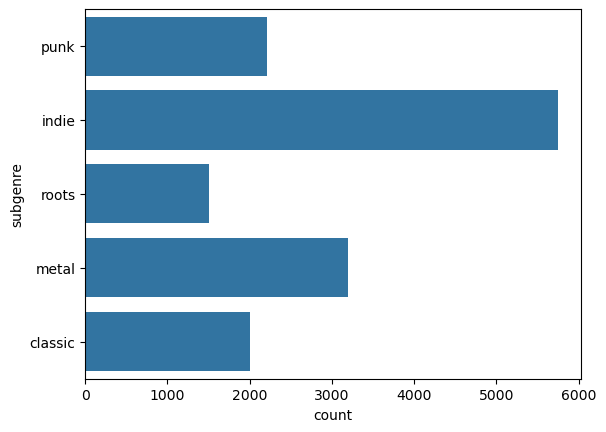

In [83]:
sns.countplot(df['subgenre'])

In [ ]:
# df.to_csv('Datasets/df_exploded.csv', index=False)

# **Merge with ``ratings``**

In [ ]:
df_artists_countries = pd.merge(df_artists_origins, df_coordinates, on=['origin'])
df_artists_countries.drop(columns=['city', 'origin_clean', 'latitude', 'longitude', 'address'], inplace=True)
df_artists_countries